This notebook will provide the functionality of assigning names to stars and their locations. 

The intended workflow is that this be used after Astrometry, but provides the setup for the later photometry steps, so it must be done before them.

By segmenting the notebooks, the goal was to improve performance, as well as creating checkpoints in the process by saving info to files.

As with previous supplementary notebooks, we needed to specify the path to the folder containing our scripts in order for the python kernal to know to check there when doing imports:

In [1]:
import sys
#My folder is at: /Users/aidanmcclung/Desktop/Summer_Exoplanets
sys.path.append('/Users/aidanmcclung/Desktop/Summer_Exoplanets') #this lets it know to look here for import statements

In [2]:
import numpy as np
import astropy.units as u
from astropy.io import fits
from astropy.wcs import WCS
from astropy.table import Table
import matplotlib.pyplot as plt
import os

from photutils.detection import DAOStarFinder
from astropy.stats import mad_std

from photutils.aperture import aperture_photometry, CircularAperture, SkyCircularAperture, SkyCircularAnnulus, ApertureStats
from astropy.coordinates import SkyCoord, FK5, Angle
from astropy.stats import sigma_clipped_stats
from photutils.detection import find_peaks
from photutils.centroids import centroid_quadratic
from photutils.profiles import RadialProfile

#from astropy.visualization import astropy_mpl_style
#plt.style.use(astropy_mpl_style)
#plt.rcParams['figure.figsize'] = [16,10]

import warnings; warnings.filterwarnings('ignore')

prop_cycle = plt.rcParams['axes.prop_cycle']
def_colors = prop_cycle.by_key()['color']
#print(def_colors) #['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'
#def_colors_lightened = ['#99cbed','#ffcc9f','#9fe59f','#efa8a8','#d4c2e5','#d6b8b2','#f4c9e7','#cccccc','#eded9e','#9aecf4']
#def_colors_darkened = ['#16537e','#bc5800','#1f701f','#961b1c','#683e8e','#623c34','#c92998','#595959','#848418','#108591']

import io
def print_to_string(*args, **kwargs):
    output = io.StringIO()
    print(*args, file=output, **kwargs)
    contents = output.getvalue()
    output.close()
    return contents

#Universal Property definitions:
globalClipboard = ""

TEMPANIMDIR = 'tempAnim'
PHOTTABLESAVEDIR = 'photTables'
FIGUREOUTDIR = ''
WORKINGDIR = 'myWorking'

In [3]:
# #should go with like, the class that manages all these things.
# def getFilepath(number,folder='output/',ext='.fits'):
#     return folder + "{:03d}".format(number) + ext

# #I feel like these converters should go in a helper module
# def hmstodays(h,m,s):
#     return h/24 + m/(24*60) + s/(24*60*60)

# def hmsToDeg(h,m,s):
#     return 15*h + 15*m/60 + 15*s/3600

# def dmsToDeg(d,m,s):
#     return d + m/60 + s/3600

# #helper class
# def getTimeFromDate(dateStr):
#     #dateStr format: YYYY-MM-DD'T'HH:MM:SS.SSS
#     split = dateStr.split(':')
#     #print(split)
#     hourStr = split[0][-2:]; minStr = split[1]; secStr = split[2]
#     second = float(secStr); minute = float(minStr); hour = float(hourStr)
#     #print(hour,minute,second)
#     time = hour + (minute + (second/60))/60
#     return time

# #this is a useful method, idk where to put it
# def genTimesFromTable(table,debug=False):
#     times = np.zeros(len(table))
#     for d,date in enumerate(table['time']):
#         if debug: print(d,date)
#         times[d] = getTimeFromDate(date)
#     return times

# #this isn't super used; should maybe go in a general purpose module though
# def diffMag(fluxV,fluxC):
#     return -2.5 * np.log10(fluxV/fluxC)

In [4]:
from QAOP.QAOP_utils import * #import all the functions from the utils package. 
#      These are those that are commented in the cell above.

print(dmsToDeg(60,5,24))

60.09


In [5]:
##These are all components of the aperture determination stuff.

def loadSources(src,sources,debug=False):
    if not src:
        try:
            sources = Table.read(WORKINGDIR+'/DAOSources'+'.fits')
            print("Loaded Sources from File.")
            if debug:
                for col in sources.colnames:  
                    sources[col].info.format = '%.8g'  # for consistent table output
                print("Loaded Sources:")
                print(sources)
        except Exception as e:
            print("error Loading Sources from file.")
            print("error:",e)
    else:
        print("Sources passed as parameter")
        if debug:
            for col in sources.colnames:  
                sources[col].info.format = '%.8g'  # for consistent table output
            print("Passed sources:")
            print(sources)
    return sources

#positions = np.transpose((sources['xcentroid'], sources['ycentroid']))  
def loadPositionsForAllSources(src=False,sources=None,debug=False):
    
    sources = loadSources(src=src,sources=sources,debug=debug)
    
    #now do the thing
    positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
    
    if debug:
        print("Positions are:")
        print(positions)
    return positions

#take high sources from that.
#wherehigh = np.where(sources['peak'] >= 12000)[0]
#print(np.take(sources,wherehigh))
def loadHighSources(threshold=20000,src=False,sources=None,debug=False):
    
    sources = loadSources(src=src,sources=sources,debug=debug)

    wherehigh = np.where(sources['peak'] >= threshold)[0]  #np.where returns an array with only one item
    wheretoohigh = np.where(sources['peak'] >= 60000)[0]
    wherehigh = np.setdiff1d(wherehigh,wheretoohigh) #only keep the ones that were high but not too high
    
    if debug:
        print(f"Where Source peaks higher than {threshold}:")
        print(wherehigh)
        print("Those sources are:")
        print(np.take(sources,wherehigh))
    return wherehigh

#imports needed: centroid_quadratic, radialprofile, numpy
def loadFWHMSFromHighSources(image,wherehigh,src=False,sources=None,debug=False):

    sources = loadSources(src=src,sources=sources,debug=debug)
    if debug: print('high indecies:',wherehigh)
    highx = np.take(sources['xcentroid'],wherehigh)
    highy = np.take(sources['ycentroid'],wherehigh)
    if debug: 
        print("High centorids:")
        print(highx)
        print(highy)
        
    #sort through all of the high stars and determine the fwhm to use for the aperture radius.
    fwhms = np.zeros(len(wherehigh))
    for i,n in enumerate(wherehigh):
        xycen = centroid_quadratic(image, xpeak=highx[i], ypeak=highy[i])
        edge_radii = np.arange(26)
        rp = RadialProfile(image, xycen, edge_radii, mask=None)
        #print(rp.gaussian_fwhm)
        fwhms[i] = rp.gaussian_fwhm
    medfwhm = np.median(fwhms)
    if debug:
        print("FWHM Array (units of pixels):")
        print(fwhms)
        print("Median of array (units of pixels):")
        print(medfwhm) #this is the value that should, in theory, be used for the radius.
        #it is in units of pixels.
    return fwhms, medfwhm

#radius=np.median(fwhms)
def createApertures(positions,radius,thiswcs,debug=False):
    """Creates apertures for all positions identified by the DAO Starfinder"""
    #create all the apertures
    apertures = CircularAperture(positions, r=radius)
    sky_apertures = apertures.to_sky(thiswcs)
    #Use a preexisting function to plot them, but we will need to give that the image number
    if debug: plotAperturesForImage(sky_apertures)
    return sky_apertures

def copyHighApertures(sky_apertures,wherehigh,clipboard=globalClipboard,debug=False):
    if debug: print("indexes to copy:",wherehigh)
    output = io.StringIO() #create an intermediate file to copy to; 
    #by doing it this way, we can copy multiple output lines. 
    #if we just told print() to print to the clipboard, we could only get one line at a time.
    for i in wherehigh:
        #sky_apertures[i].to_pixel(w).plot(color='red', lw=1.5, alpha=0.7) #plot apertures
        #print(sky_apertures[i])
        print(sky_apertures[i].positions.transform_to('icrs'),file=output) #prints the aperture info to a temp file
    clipboard = output.getvalue() #makes the clipboard object the string that would have been printed
    output.close()
    #parsingClipboard = contents
    if debug:
        print("Parsing Clipboard:")
        print(clipboard)
    return clipboard

In [6]:
#this is helpful for debugging 
def plotAperturesForImage(apertures,imgnumber=1):
    fn = getFilepath(imgnumber) #getFilepath is in QAOP_utils.
    with fits.open(fn) as hdul:
        head = hdul[0].header
        data = hdul[0].data
        thisw = WCS(hdul[0].header)
        thisDate = head["date-obs"]
        image = data
        if isinstance(apertures,SkyCircularAperture):
            sky_apertures = apertures
            pix_apertures = sky_apertures.to_pixel(thisw)
        else: pix_apertures = apertures
        plt.figure(figsize=(15,15))
        plt.title(fn + str(head['date-obs']))
        plt.imshow(image, cmap='gray', origin='lower',norm='log')
        pix_apertures.plot(color='yellow', lw=1.5, alpha=0.8)
        plt.colorbar()
        plt.show()

2460164.7652895832
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 286.84401794  49.0835286874  
CRPIX : 1640.15063477  148.068256378  
CD1_1 CD1_2  : 0.000265692505657  5.58786209917e-06  
CD2_1 CD2_2  : -5.60130024177e-06  0.000265652912657  
NAXIS : 3072  2048
Sources passed as parameter
Loaded Sources from File.


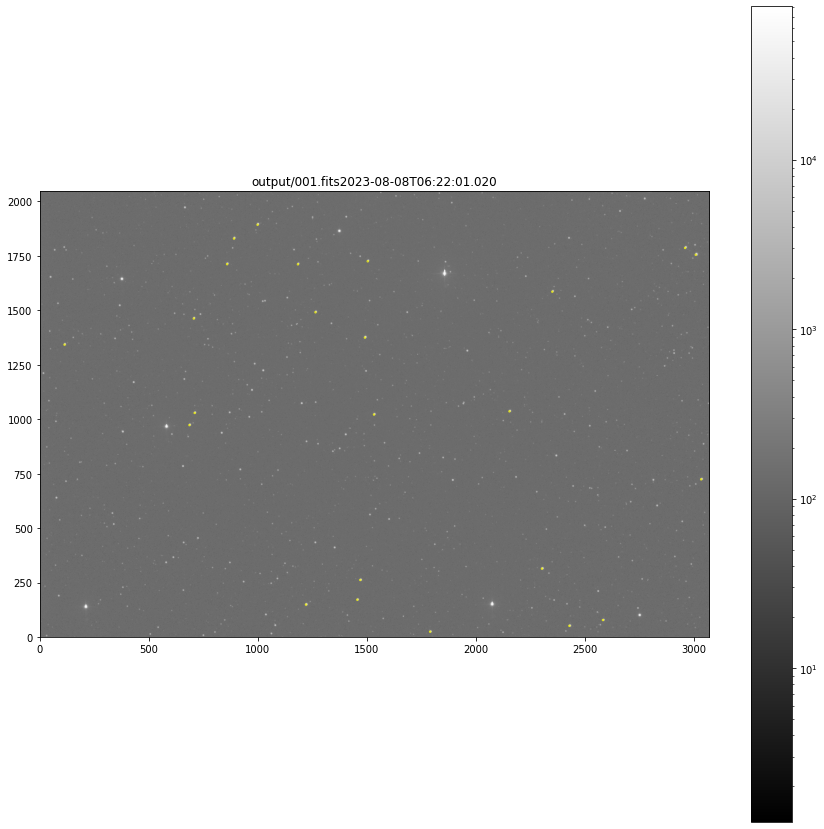

pc: <SkyCoord (ICRS): (ra, dec) in deg
    (286.90466917, 49.05028138)>
<SkyCoord (ICRS): (ra, dec) in deg
    (287.16389622, 49.05347225)>
<SkyCoord (ICRS): (ra, dec) in deg
    (287.22654558, 49.05942281)>
<SkyCoord (ICRS): (ra, dec) in deg
    (286.67463815, 49.08638769)>
<SkyCoord (ICRS): (ra, dec) in deg
    (286.7704238, 49.09110339)>
<SkyCoord (ICRS): (ra, dec) in deg
    (286.77672522, 49.11508899)>
<SkyCoord (ICRS): (ra, dec) in deg
    (287.11547812, 49.12396441)>
<SkyCoord (ICRS): (ra, dec) in deg
    (287.41663541, 49.22759817)>
<SkyCoord (ICRS): (ra, dec) in deg
    (286.46315164, 49.30767114)>
<SkyCoord (ICRS): (ra, dec) in deg
    (286.8085626, 49.31639915)>
<SkyCoord (ICRS): (ra, dec) in deg
    (286.47325413, 49.32238038)>
<SkyCoord (ICRS): (ra, dec) in deg
    (287.06199622, 49.31661829)>
<SkyCoord (ICRS): (ra, dec) in deg
    (286.23154592, 49.40800631)>
<SkyCoord (ICRS): (ra, dec) in deg
    (286.79452862, 49.41046526)>
<SkyCoord (ICRS): (ra, dec) in deg
    (286.47

In [7]:
parsingClipboard = ''

#this function needs to be annotated, or split even more; have it follow a notebook?
#Or we could walk through each step in a notebook, and then have a function at the end.
def determineApertures(index=1,debug=False):
    figsize = (16,10)
    fn = getFilepath(index)
    #with fits.open(fn) as hdul:
        #head = hdul[0].header
        #data = hdul[0].data
        #thisDate= head['date-obs']
        #w = WCS(hdul[0].header)
        
        #Print basic info; the time and location of image
        #print(head['JD'])
        #w.printwcs()
        
        #sig = 3.0
        #mean, median, std = sigma_clipped_stats(data, sigma=sig)
        
        #back = calculateBackground(data)
        #image = data #- back #We no longer subtract the background and instead do that during photometry
        
        #if debug:
            #plt.figure(figsize=figsize)
            #plt.imshow(data,alpha=1,cmap='gray_r',origin='lower')
            #plt.colorbar()
            #plt.title(head['date-obs'])
            #plt.show()
            #print("Sigma stats on data:")
            #print('mean:',mean,'median:',median,'std:',std)
        
        #daofind = DAOStarFinder(fwhm=4.0, threshold=5.0 * std) 
        #daofind = DAOStarFinder(fwhm=2.37*sig, threshold=5.0 * std)  
        #sources = daofind(image)
        #print("sources type:",type(sources)) #QTable. has read/write
        #save the sources table:
        #sources.write(WORKINGDIR+'/DAOSources'+'.fits',format='fits',overwrite=True)
        
        
        #we need to load these stats in order to make the threshold for the peak finding
        #mean, median, std = sigma_clipped_stats(image, sigma=3.0)
        #threshold = median + (5.0 * std)
        #Find the peaks over the threshold defined. 
        #   box_size means all peaks will be seperated by at least 5 pixels
        #peakTbl = find_peaks(image, threshold, box_size=11)
        #now we save the peaks too
        #peakTbl.write(WORKINGDIR+'/foundPeaks'+'.fits',format='fits',overwrite=True)
        
        positions = loadPositionsForAllSources(src=True,sources=sources,debug=debug)
        
        wherehigh = loadHighSources(debug=debug)
        
        #fwhms, medfwhm = loadFWHMSFromHighSources(image,wherehigh,debug=debug)
        fwhms, medfwhm = [5,5,5,5,5], 5
        
        if debug:
            
            print("sigmaStats on image:",mean,median,std)
            peakTbl['peak_value'].info.format = '%.8g'  # for consistent table output
            print("Peaks over threshold",peakTbl)#[:10])  # print only the first 10 peaks

            plt.figure(figsize=figsize)
            plt.hist(peakTbl['peak_value'],bins=30)
            plt.gca().set_yscale('log')
            plt.title("Number of peaks over threshold of {0}".format(threshold,"%.3f"))
            plt.show()

            plt.figure(figsize=figsize)
            plt.imshow(image, cmap='gray')
            apertures.plot(color='yellow', lw=1.5, alpha=0.5)
            plt.colorbar()
            #plt.show()
            #print("Aperture Result:",sky_apertures)
        
        sky_apertures = createApertures(positions=positions,radius=2,thiswcs=w,debug=debug)
        #print(sky_apertures)
        tempclip = ""
        parsingClipboard = copyHighApertures(sky_apertures,wherehigh,clipboard=tempclip)
        
        #plot the final selected apertures
        plotAperturesForImage(sky_apertures[wherehigh],number=index)
        
        return sky_apertures, parsingClipboard
    
AllSA,parsingClipboard = determineApertures(index=1,debug=False)
print('pc:',parsingClipboard)

['<SkyCoord (ICRS): (ra, dec) in deg\n    (286.90466917, 49.05028138)', '\n<SkyCoord (ICRS): (ra, dec) in deg\n    (287.16389622, 49.05347225)', '\n<SkyCoord (ICRS): (ra, dec) in deg\n    (287.22654558, 49.05942281)', '\n<SkyCoord (ICRS): (ra, dec) in deg\n    (286.67463815, 49.08638769)', '\n<SkyCoord (ICRS): (ra, dec) in deg\n    (286.7704238, 49.09110339)', '\n<SkyCoord (ICRS): (ra, dec) in deg\n    (286.77672522, 49.11508899)', '\n<SkyCoord (ICRS): (ra, dec) in deg\n    (287.11547812, 49.12396441)', '\n<SkyCoord (ICRS): (ra, dec) in deg\n    (287.41663541, 49.22759817)', '\n<SkyCoord (ICRS): (ra, dec) in deg\n    (286.46315164, 49.30767114)', '\n<SkyCoord (ICRS): (ra, dec) in deg\n    (286.8085626, 49.31639915)', '\n<SkyCoord (ICRS): (ra, dec) in deg\n    (286.47325413, 49.32238038)', '\n<SkyCoord (ICRS): (ra, dec) in deg\n    (287.06199622, 49.31661829)', '\n<SkyCoord (ICRS): (ra, dec) in deg\n    (286.23154592, 49.40800631)', '\n<SkyCoord (ICRS): (ra, dec) in deg\n    (286.794528

 afhdklahlkf


286.90466917, 49.05028138


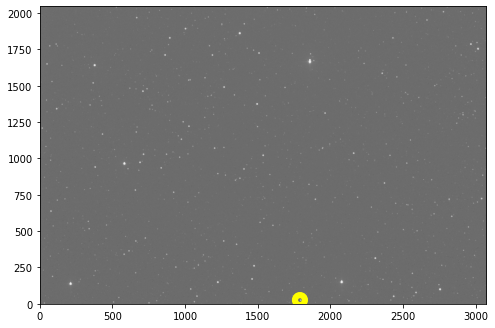

A key is required for the point 286.90466917, 49.05028138 sCA


287.16389622, 49.05347225


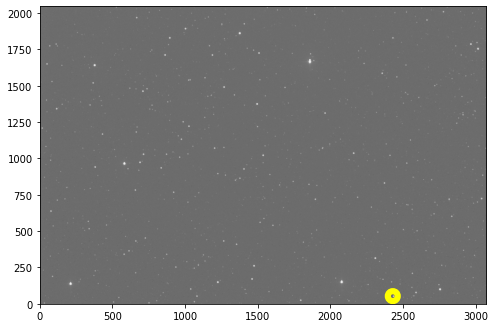

A key is required for the point 287.16389622, 49.05347225 sCB


287.22654558, 49.05942281


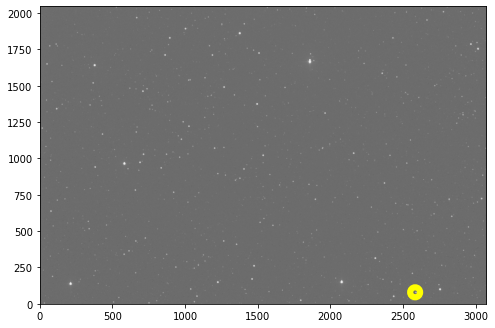

A key is required for the point 287.22654558, 49.05942281 sCD


286.67463815, 49.08638769


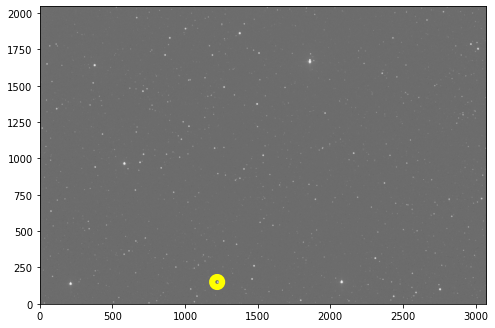

A key is required for the point 286.67463815, 49.08638769 sCE


286.7704238, 49.09110339


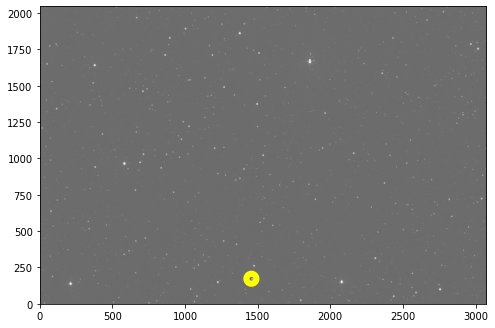

A key is required for the point 286.7704238, 49.09110339 sCF


286.77672522, 49.11508899


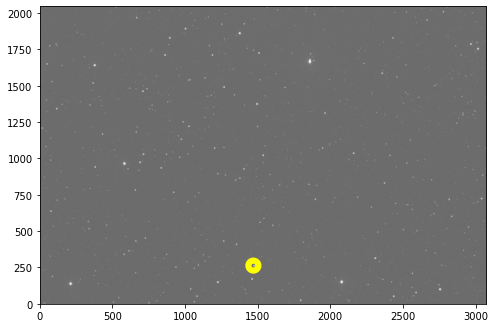

A key is required for the point 286.77672522, 49.11508899 sCG


287.11547812, 49.12396441


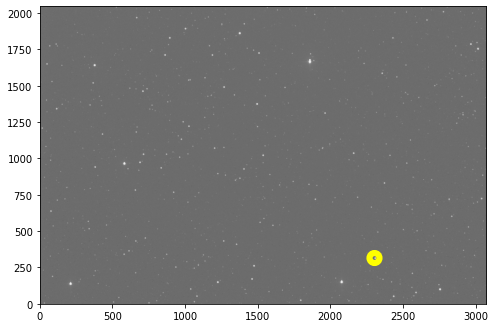

A key is required for the point 287.11547812, 49.12396441 sCH


287.41663541, 49.22759817


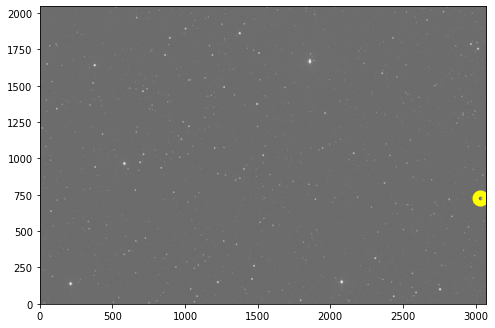

A key is required for the point 287.41663541, 49.22759817 sCI


286.46315164, 49.30767114


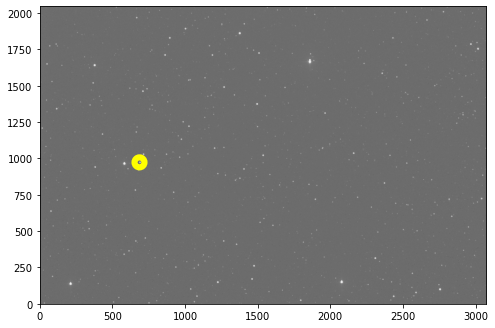

A key is required for the point 286.46315164, 49.30767114 sA


286.8085626, 49.31639915


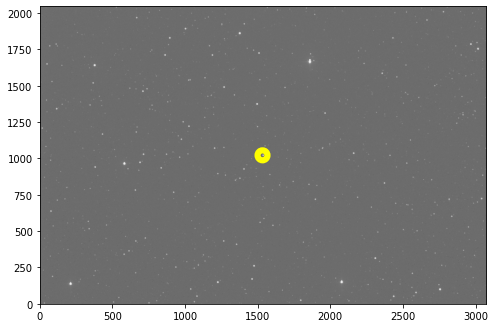

A key is required for the point 286.8085626, 49.31639915 sB


286.47325413, 49.32238038


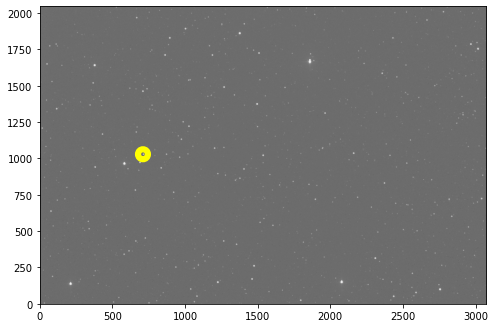

A key is required for the point 286.47325413, 49.32238038 sC


287.06199622, 49.31661829


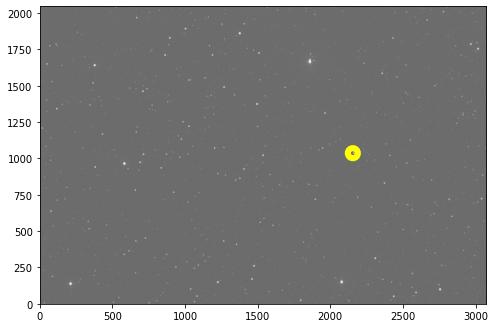

A key is required for the point 287.06199622, 49.31661829 sD


286.23154592, 49.40800631


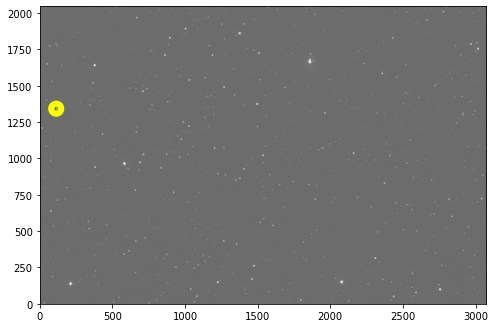

A key is required for the point 286.23154592, 49.40800631 sCJ


286.79452862, 49.41046526


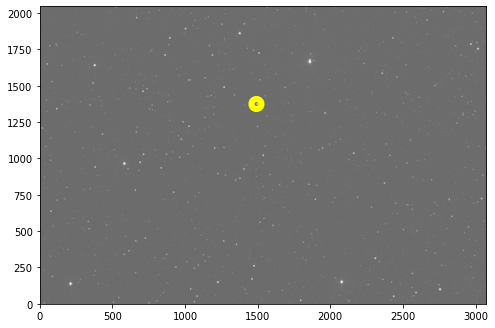

A key is required for the point 286.79452862, 49.41046526 sCK


286.47444738, 49.4375753


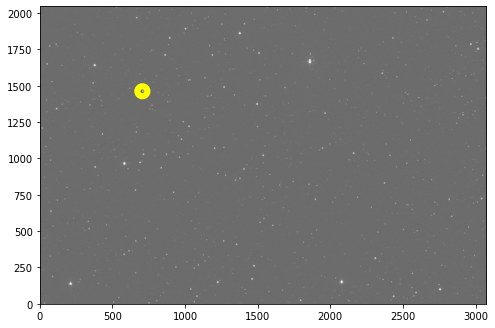

A key is required for the point 286.47444738, 49.4375753 sCL


286.70276313, 49.44250155


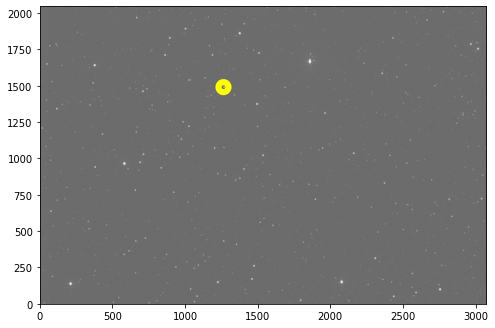

A key is required for the point 286.70276313, 49.44250155 sBA


287.14774105, 49.46122051


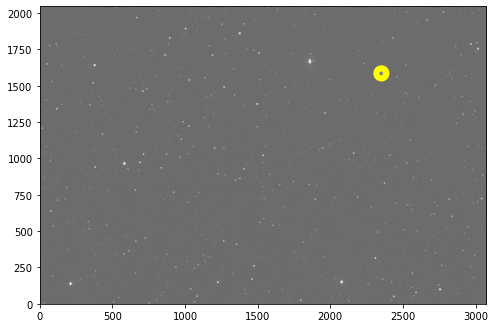

A key is required for the point 287.14774105, 49.46122051 sBB


286.53864766, 49.50311876


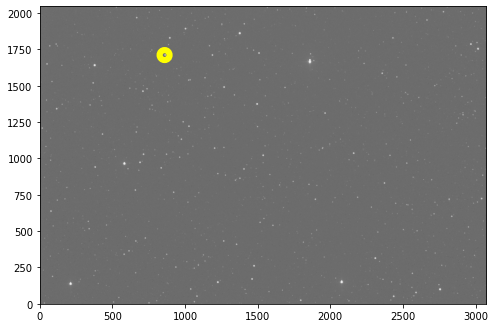

A key is required for the point 286.53864766, 49.50311876 sBC


286.67159369, 49.5014282


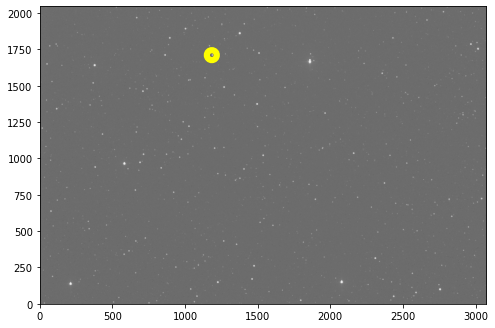

A key is required for the point 286.67159369, 49.5014282 sBD


286.80273809, 49.50341298


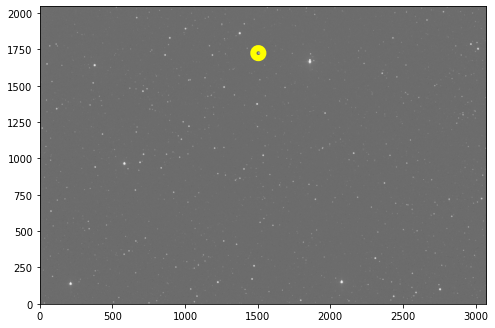

A key is required for the point 286.80273809, 49.50341298 sBE


287.41863945, 49.50150268


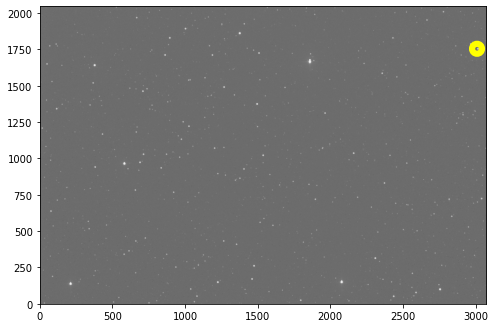

A key is required for the point 287.41863945, 49.50150268 sCM


287.39894872, 49.51016755


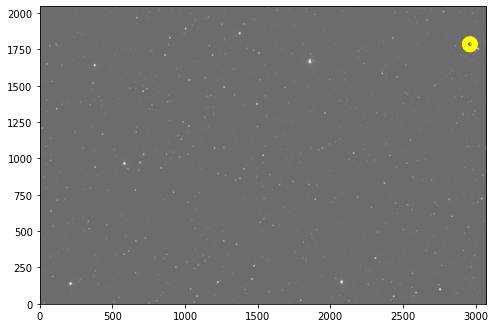

A key is required for the point 287.39894872, 49.51016755 sCN


286.5524334, 49.53424676


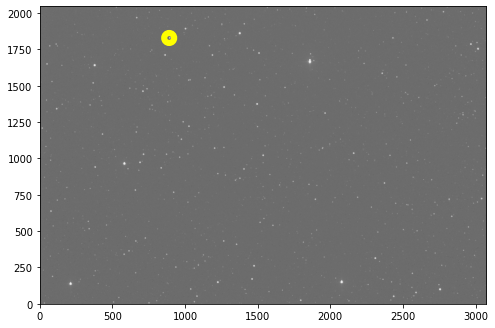

A key is required for the point 286.5524334, 49.53424676 sCO


286.5972112, 49.55059329


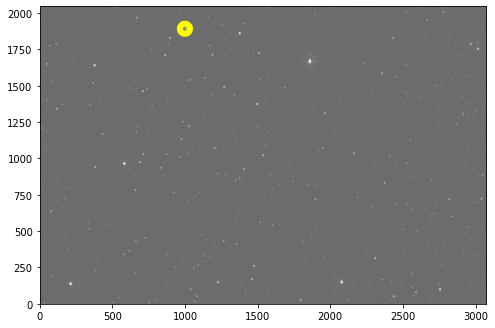

A key is required for the point 286.5972112, 49.55059329 sCP


({'sCA': 286.90466917,
  'sCB': 287.16389622,
  'sCD': 287.22654558,
  'sCE': 286.67463815,
  'sCF': 286.7704238,
  'sCG': 286.77672522,
  'sCH': 287.11547812,
  'sCI': 287.41663541,
  'sA': 286.46315164,
  'sB': 286.8085626,
  'sC': 286.47325413,
  'sD': 287.06199622,
  'sCJ': 286.23154592,
  'sCK': 286.79452862,
  'sCL': 286.47444738,
  'sBA': 286.70276313,
  'sBB': 287.14774105,
  'sBC': 286.53864766,
  'sBD': 286.67159369,
  'sBE': 286.80273809,
  'sCM': 287.41863945,
  'sCN': 287.39894872,
  'sCO': 286.5524334,
  'sCP': 286.5972112},
 {'sCA': 49.05028138,
  'sCB': 49.05347225,
  'sCD': 49.05942281,
  'sCE': 49.08638769,
  'sCF': 49.09110339,
  'sCG': 49.11508899,
  'sCH': 49.12396441,
  'sCI': 49.22759817,
  'sA': 49.30767114,
  'sB': 49.31639915,
  'sC': 49.32238038,
  'sD': 49.31661829,
  'sCJ': 49.40800631,
  'sCK': 49.41046526,
  'sCL': 49.4375753,
  'sBA': 49.44250155,
  'sBB': 49.46122051,
  'sBC': 49.50311876,
  'sBD': 49.5014282,
  'sBE': 49.50341298,
  'sCM': 49.50150268,

In [8]:
### testStr="<SkyCoord (ICRS): (ra, dec) in deg\r\t(245.29451485, -23.56902065)>\r<SkyCoord (ICRS): (ra, dec) in deg\r\t(245.44045207, -23.54846956)>\r<SkyCoord (ICRS): (ra, dec) in deg\r\t(245.3700522, -23.54441245)>\r<SkyCoord (ICRS): (ra, dec) in deg\r(245.34466987, -23.4878273)>\r<SkyCoord (ICRS): (ra, dec) in deg\r\t(245.31859543, -23.45355821)>"


#this is a very specific use case; I should refine it a bit more.
#should also maybe have it auto ask for an input if no clipboard is passed?
def parseForRADEC(stringtoparse,keys=None):
    #stringtoparse = np.array(stringtoparse)
    splitStr = stringtoparse.split('>')
    print(splitStr)
    splitStr = [ss.strip("\r") for ss in splitStr]
    splitStr = [ss.strip("\n") for ss in splitStr]
    splitStr = [ss.strip("<SkyCoord (ICRS): (ra, dec) in deg") for ss in splitStr]
    splitStr = [ss.strip("\n") for ss in splitStr]
    
    splitStr = [ss.strip("\r") for ss in splitStr]
    splitStr = [ss.strip("\t") for ss in splitStr]
    #print(splitStr)
    splitStr = [ss.strip(")>") for ss in splitStr]
    splitStr = [ss.strip("(") for ss in splitStr]
    splitStr = [ss.strip("\n") for ss in splitStr]
    
    splitStr = [ss.strip("    (") for ss in splitStr]
    [splitStr.remove('') for i in range(splitStr.count(''))]
    
    print(splitStr)
    
    RAs = {}; DECs = {}
    
    if (keys == None):
        
        print("Keys must be determined.")
        print("Please press enter to skip showing plots, or enter any character to show them")
        showPlot = input()
        #autoFill = input("Please type 'auto' to use a basic format")
        for i,st in enumerate(splitStr):
            print(splitStr[i])
            ra,dec = splitStr[i].split(','); ra = float(ra); dec=float(dec)
            key = askForKey(ra=ra,dec=dec,showPlot=bool(showPlot))
            RAs[key] = ra; DECs[key] = dec
    elif keys:
        for i,k in enumerate(keys):
            ra,dec = splitStr[i].split(','); ra = float(ra); dec=float(dec)
            RAs[k] = ra; DECs[k] = dec
    return RAs,DECs

def plotApertureToFindKey(ra,dec,number=1,**pltkwargs):
    fn = getFilepath(number)
    with fits.open(fn) as hdul:
        data = hdul[0].data
        thisw = WCS(hdul[0].header)
        image = data
        
        pos = SkyCoord(ra=ra*u.deg,dec=dec*u.deg,frame='icrs')
        sky_ap = SkyCircularAperture(pos,r=20*u.arcsec)
        pix_apertures = sky_ap.to_pixel(thisw)
        
        plt.figure(figsize=(8,8))
        plt.imshow(image, cmap='gray', origin='lower',**pltkwargs)
        pix_apertures.plot(color='yellow', lw=10, alpha=1)
        #plt.colorbar()
        plt.show()
        #plt.show(block=False)
        #plt.pause(3)
        #plt.close()

def askForKey(ra,dec,showPlot=False):
    if showPlot:
        plotApertureToFindKey(ra=ra,dec=dec,number=1,norm='log')
    key = input(f"A key is required for the point {ra}, {dec}")
    return key

    
    
#parseForRADEC(input(),['target','check','c1','c2','c3','c4'])
#print(repr(parsingClipboard))
parseForRADEC(parsingClipboard)

In [10]:
RAs = {'sCA': 286.90466917,
  'sCB': 287.16389622,
  'sCD': 287.22654558,
  'sCE': 286.67463815,
  'sCF': 286.7704238,
  'sCG': 286.77672522,
  'sCH': 287.11547812,
  'sCI': 287.41663541,
  'sA': 286.46315164,
  'sB': 286.8085626,
  'sC': 286.47325413,
  'sD': 287.06199622,
  'sCJ': 286.23154592,
  'sCK': 286.79452862,
  'sCL': 286.47444738,
  'sBA': 286.70276313,
  'sBB': 287.14774105,
  'sBC': 286.53864766,
  'sBD': 286.67159369,
  'sBE': 286.80273809,
  'sCM': 287.41863945,
  'sCN': 287.39894872,
  'sCO': 286.5524334,
  'sCP': 286.5972112}

DECs = {'sCA': 49.05028138,
  'sCB': 49.05347225,
  'sCD': 49.05942281,
  'sCE': 49.08638769,
  'sCF': 49.09110339,
  'sCG': 49.11508899,
  'sCH': 49.12396441,
  'sCI': 49.22759817,
  'sA': 49.30767114,
  'sB': 49.31639915,
  'sC': 49.32238038,
  'sD': 49.31661829,
  'sCJ': 49.40800631,
  'sCK': 49.41046526,
  'sCL': 49.4375753,
  'sBA': 49.44250155,
  'sBB': 49.46122051,
  'sBC': 49.50311876,
  'sBD': 49.5014282,
  'sBE': 49.50341298,
  'sCM': 49.50150268,
  'sCN': 49.51016755,
  'sCO': 49.53424676,
  'sCP': 49.55059329}

In [12]:
#print(RAs)
#print(DECs)

#using my eyes, I have determined that 'sK' and "target" are the same star.

In [12]:
#Alternatively, we can just add the locations that we know from having planned...
#Which are: 19h07m14.05s 49d18m59.12s
RAs['target'] = hmsToDeg(19,7,14.05)
DECs['target'] = dmsToDeg(49,18,59.12)

In [11]:
#print(hmsToDeg(20,13,31.65))

In [10]:
#def getPos(key):
#    ra = RAs[key]; dec = DECs[key] ; sc = SkyCoord(ra=ra*u.deg,dec=dec*u.deg,frame='icrs')
#    return sc

#print(getPos('target'))


#colors1 = {'target':'firebrick','check':'salmon','c1':'sandybrown','c2':'salmon','c3':'sienna','c4':'chocolate'}
#colors2 = {'target':'slateblue','check':'cornflowerblue','c1':'navy','c2':'deepskyblue','c3':'steelblue','c4':'cadetblue'}
#colors3 = {'target':'olivedrab','check':'chartreuse','c1':'forestgreen','c2':'seagreen','c3':'aquamarine','c4':'yellowgreen'}

In [9]:
#okay, well, all that shenanigans aside, now I need to save those keys and their locations.

#namelocTab = Table(names=['Name','RA','DEC'],dtype=[str,float,float])
#print(namelocTab)


In [8]:
#rowsfortable = []
#for n in RAs.keys():
#    rowtoadd = np.hstack((n,RAs[n],DECs[n]))
#    rowsfortable.append(rowtoadd)
#print(rowsfortable)

In [6]:
#namelocTab = Table(rows=rowsfortable,names=['Name','RA','DEC'],dtype=[str,float,float])
#print(namelocTab)
#namelocTab.write('nameloc'+'.csv',overwrite=True)

In [7]:
#posTable = Table.read('myWorking/DAOSources.fits')
#posTable.show_in_notebook()

In [5]:
class nameset():
    RAs = {}
    DECs = {}
    
    def __init__(self,img_filepath,workingdir='myWorking'):
        import os
        if not os.listdir().count(workingdir): os.mkdir(workingdir)
        self.workingdir = workingdir
        with fits.open(img_filepath) as hdul: #hdul is Header Data Unit List. An HDU is fundamental of fits format
            self.image = hdul[0].data
            self.wcs = WCS(hdul[0].header)
            self.date = hdul[0].header['date-obs']
            
    def addTarget(self,target_ra,target_dec):
        self.RAs['target'] = target_ra
        self.DECs['target'] = target_dec
        
    def createSourceTable(self,sigma=3.0,fwhm=4.0):
        #from astropy.stats import sigma_clipped_stats
        #from photutils.detection import DAOStarFinder
        
        mean, median, std = sigma_clipped_stats(data, sigma=sigma)
        ## Here, threshold is what it will consider a star (ie, what we would consider just noise)
        ##  This is not the same threshold as we will use to choose what stars to use for analysis later.
        threshold = median + (5.0 * std)
        daofind = DAOStarFinder(fwhm=fwhm, threshold=threshold)
        #This is the important line!
        sources = daofind(image)
        
        ##  I was curious, and figured this wasn't hurting to stick around:
        #print("sources type:",type(sources)) #QTable. has read/write
        ##  and now we save the sources table:
        sources.write(WORKINGDIR+'/DAOSources'+'.fits',format='fits',overwrite=True)
        self.sources = sources
        
    def createPeakTable(self,sigma=3.0):
        """ This method is very similar in purpose to createSourceTable(), 
        but with a bit less going on so that it's easier to understand. I don't think we end up using it
        in the default operation, but it's still here. """
        
        #from astropy.stats import sigma_clipped_stats
        #from photutils.detection import find_peaks
        
        mean, median, std = sigma_clipped_stats(self.image, sigma=sigma)
        ## Here, threshold is what it will consider a star (ie, what we would consider just noise)
        ##  This is not the same threshold as we will use to choose what stars to use for analysis later.
        threshold = median + (5.0 * std)
        #Find the peaks over the threshold defined. 
        #   box_size means all peaks will be seperated by at least 5 pixels
        peakTbl = find_peaks(image, threshold, box_size=11)
        #now we save the peaks too
        peakTbl.write(WORKINGDIR+'/foundPeaks'+'.fits',format='fits',overwrite=True)
        self.peakTable = peakTbl
        
    def loadHighSources(peaks_higher_than=20000,src=False,sources=None,debug=False):

        sources = loadSources(src=src,sources=sources,debug=debug)

        wherehigh = np.where(sources['peak'] >= threshold)[0]  #np.where returns an array with only one item
        wheretoohigh = np.where(sources['peak'] >= 60000)[0]
        wherehigh = np.setdiff1d(wherehigh,wheretoohigh) #only keep the ones that were high but not too high

        if debug:
            print(f"Where Source peaks higher than {threshold}:")
            print(wherehigh)
            print("Those sources are:")
            print(np.take(sources,wherehigh))
        return wherehigh
            
    def exportcsv(self,savename='nameloc'):
        rowsfortable = []
        for n in RAs.keys():
            rowtoadd = np.hstack((n,RAs[n],DECs[n]))
            rowsfortable.append(rowtoadd)
        #print(rowsfortable)
        namelocTab = Table(rows=rowsfortable,names=['Name','RA','DEC'],dtype=[str,float,float])
        namelocTab.write(savename+'.csv', overwrite=True)